In [1]:
import os
import torch

# from easy_to_hard_data import *

import errno
import os
import os.path
import tarfile
import urllib.request as ur
from typing import Optional, Callable

import numpy as np
import torch
from tqdm import tqdm

GBFACTOR = float(1 << 30)


def extract_zip(path, folder):
    file = tarfile.open(path)
    file.extractall(folder)
    file.close


def download_url(url, folder):
    filename = url.rpartition('/')[2]
    path = os.path.join(folder, filename)

    if os.path.exists(path) and os.path.getsize(path) > 0:
        print('Using existing file', filename)
        return path
    print('Downloading', url)
    makedirs(folder)
    # track downloads
#     ur.urlopen(f"http://avi.koplon.com/hit_counter.py?next={url}")
    data = ur.urlopen(url)
    print(data.info())
    size = int(data.info()["Content-Length"])
    chunk_size = 1024*1024
    num_iter = int(size/chunk_size) + 2

    downloaded_size = 0

    try:
        with open(path, 'wb') as f:
            pbar = tqdm(range(num_iter))
            for i in pbar:
                chunk = data.read(chunk_size)
                downloaded_size += len(chunk)
                pbar.set_description("Downloaded {:.2f} GB".format(float(downloaded_size)/GBFACTOR))
                f.write(chunk)
    except:
        if os.path.exists(path):
             os.remove(path)
        raise RuntimeError('Stopped downloading due to interruption.')

    return path


def makedirs(path):
    try:
        os.makedirs(os.path.expanduser(os.path.normpath(path)))
    except OSError as e:
        if e.errno != errno.EEXIST and os.path.isdir(path):
            raise e
            

class NoisyImageDataset(torch.utils.data.Dataset):
    base_folder = "noisy_image_data"
    url = "https://www.dropbox.com/s/gamc8j5vqbvushj/noisy_image_data.tar.gz"
    lengths = [0.1,0.2,0.3,0.4,0.5]
    download_list = [f"data_{l}.pth" for l in lengths] + [f"targets_{l}.pth" for l in lengths]

    def __init__(self, root: str, num_bits: float = 0.1, download: bool = True, train: bool = True):

        self.root = root

#         if download:
#             self.download()

        print(f"Loading data with {num_bits} bits.")

        targets_path = os.path.join(root, self.base_folder, f"data_{num_bits}.pth")
        inputs_path = os.path.join(root, self.base_folder, f"targets_{num_bits}.pth")
        self.inputs = torch.tensor(torch.load(inputs_path), dtype=torch.float64)
        self.targets = torch.load(targets_path)
        print(type(self.inputs), type(self.targets))
        self.train = train

        if train:
            print("Training data using pre-set indices [0, 8000).")
            idx_start = 0
            idx_end = 8000
        else:
            print("Testing data using pre-set indices [8000, 10000).")
            idx_start = 8000
            idx_end = 10000

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]

    def __len__(self):
        return self.inputs.size(0)

    def _check_integrity(self) -> bool:
        root = self.root
        for fentry in self.download_list:
            fpath = os.path.join(root, self.base_folder, fentry)
            if not os.path.exists(fpath):
                return False
        return True

    # def download(self) -> None:
    #     if self._check_integrity():
    #         print('Files already downloaded and verified')
    #         return
    #     path = download_url(self.url, self.root)
    #     extract_zip(path, self.root)
    #     os.unlink(path)
        
        
data = NoisyImageDataset("data")

len(data)

Loading data with 0.1 bits.
<class 'torch.Tensor'> <class 'torch.Tensor'>
Training data using pre-set indices [0, 8000).


10000

In [2]:
import argparse

parser = argparse.ArgumentParser(description="Deep Thinking")
parser.add_argument("--checkpoint", default="check_default", type=str,
                    help="where to save the network")
parser.add_argument("--data_path", default="../data", type=str, help="path to data files")
parser.add_argument("--depth", default=1, type=int, help="depth of the network")
parser.add_argument("--epochs", default=200, type=int, help="number of epochs for training")
parser.add_argument("--eval_end", default=700000, type=int, help="end index for eval data")
parser.add_argument("--eval_start", default=600000, type=int,
                    help="start index for eval data")
parser.add_argument("--hist", action="store_true", help="save histogram history?")
parser.add_argument("--lr", default=0.1, type=float, help="learning rate")
parser.add_argument("--lr_decay", default="step", type=str, help="which kind of lr decay")
parser.add_argument("--lr_factor", default=0.1, type=float, help="learning rate decay factor")
parser.add_argument("--lr_schedule", nargs="+", default=[100, 150], type=int,
                    help="how often to decrease lr")
parser.add_argument("--model", default="perceiver", type=str, help="model for training")
parser.add_argument("--model_path", default=None, type=str, help="where is the model saved?")
parser.add_argument("--no_shuffle", action="store_false", dest="shuffle",
                    help="shuffle training data?")
parser.add_argument("--optimizer", default="adam", type=str, help="optimizer")
parser.add_argument("--output", default="output_default", type=str, help="output subdirectory")
parser.add_argument("--quick_test", action="store_true", help="only test on eval data")
parser.add_argument("--save_json", action="store_true", help="save json")
parser.add_argument("--save_period", default=None, type=int, help="how often to save")
parser.add_argument("--test_batch_size", default=500, type=int, help="batch size for testing")
parser.add_argument("--test_iterations", default=None, type=int,
                    help="how many, if testing with a different number iterations")
parser.add_argument("--test_mode", default="default", type=str, help="testing mode")
parser.add_argument("--train_batch_size", default=128, type=int,
                    help="batch size for training")
parser.add_argument("--train_log", default="train_log.txt", type=str,
                    help="name of the log file")
parser.add_argument("--train_mode", default="default", type=str, help="training mode")
parser.add_argument("--val_period", default=20, type=int, help="how often to validate")
parser.add_argument("--warmup_period", default=5, type=int, help="warmup period")
parser.add_argument("--width", default=4, type=int, help="width of the network")

OUTPUT="test"
#RNN_MODEL_PATH="check_default/recur_resnet_adam_depth=28_width=2_lr=0.1_batchsize=64_at19_epoch=19_log.pth"
# RNN_MODEL_PATH="checkpoints/recur_resnet_adam_depth=28_width=2_lr=0.1_batchsize=64_at0_epoch=0_log.pth"
#RNN_MODEL_PATH="check_default/recur_resnet_adam_depth=28_width=2_lr=0.1_batchsize=64_at4_epoch=4_log.pth"
RNN_MODEL_PATH="check_default/recur_resnet_adam_depth=28_width=2_lr=0.0001_batchsize=64_at9_epoch=9_log.pth"

args_str = f"""
--save_json \
--output {OUTPUT} \
--model recur_resnet \
--epochs 0 \
--width 2 \
--depth 28 
--train_batch_size 64 \
--test_batch_size 64 \
--model_path {RNN_MODEL_PATH} \
--test_iterations 5

"""
args = parser.parse_args(args_str.split())


In [10]:
# load data

import torch.utils.data as data

from utils import train, test, OptimizerWithSched, load_model_from_checkpoint, \
    get_dataloaders, to_json, get_optimizer, to_log_file, now, get_model

# trainloader, testloader = get_dataloaders(args.train_batch_size, args.test_batch_size, shuffle=args.shuffle)

train_data = NoisyImageDataset("./data", train=True,num_bits=0.5)
test_data = NoisyImageDataset("./data", train=False)
# train_data = MazeDataset("./data", train=True)
# test_data = MazeDataset("./data", train=False)


train_batch_size = args.train_batch_size
test_batch_size = args.test_batch_size
shuffle = args.shuffle

trainloader = data.DataLoader(train_data, num_workers=0, batch_size=train_batch_size,
                              shuffle=shuffle, drop_last=True)
testloader = data.DataLoader(test_data, num_workers=0, batch_size=test_batch_size,
                             shuffle=False, drop_last=False)

Loading data with 0.5 bits.
<class 'torch.Tensor'> <class 'torch.Tensor'>
Training data using pre-set indices [0, 8000).
Loading data with 0.1 bits.
<class 'torch.Tensor'> <class 'torch.Tensor'>
Testing data using pre-set indices [8000, 10000).


  0%|                                              | 0/156 [00:00<?, ?it/s]

torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])


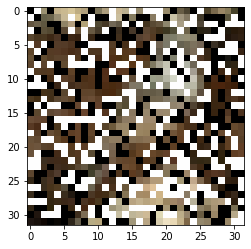

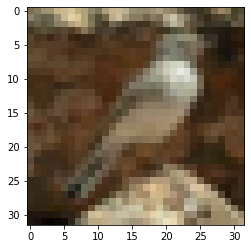

In [11]:
# examine data

import random
import matplotlib.pyplot as plt

def show_image(image):
    image = image.transpose(0, 1).transpose(1, 2)/256
    plt.imshow(image) 
    plt.show()


device = "cpu"

for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader, leave=False)):
    inputs, targets = inputs.to(device), targets.to(device)
    print(inputs.shape)
    print(targets.shape)
    
    idx = random.randint(0,len(inputs)-1)
#     image = inputs[idx].transpose(0, 1).transpose(1, 2)/256
#     target = targets[idx].transpose(0, 1).transpose(1, 2)/256
    show_image(inputs[idx])
    show_image(targets[idx])
    
    #display(image.type)
    #display(target.type)
    
    break

In [12]:
# model inference

# load model from path if a path is provided
print(f"Loading model from checkpoint {args.model_path}...")
net, start_epoch, optimizer_state_dict = load_model_from_checkpoint(args.model,
                                                                    args.model_path,
                                                                    args.width,
                                                                    args.depth)
print(net.iters)
start_epoch += 1


net = torch.nn.DataParallel(net, device_ids=None)
# pytorch_total_params = sum(p.numel() for p in net.parameters())
# optimizer = get_optimizer(args.optimizer, net, args.lr)

Loading model from checkpoint check_default/recur_resnet_adam_depth=28_width=2_lr=0.0001_batchsize=64_at9_epoch=9_log.pth...
6


In [13]:
device = 'cuda:0'

  0%|                                              | 0/156 [00:00<?, ?it/s]

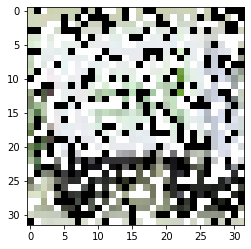

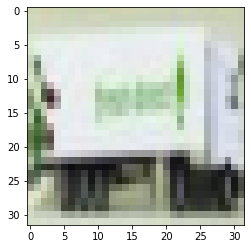

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration 0
iteration 5
iteration 10
iteration 15
iteration 20
iteration 25
iteration 30
iteration 35
iteration 40
iteration 45


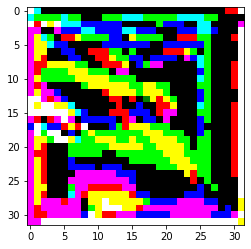

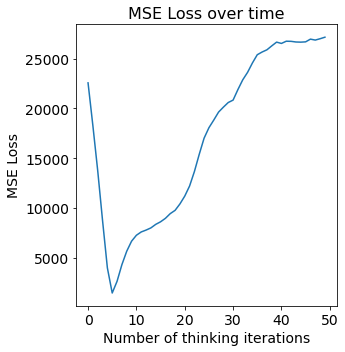

In [23]:
# display thoughts over more thinking

# net, start_epoch, optimizer_state_dict = load_model_from_checkpoint(args.model,
#                                                                     args.model_path,
#                                                                     args.width,
#                                                                     args.depth)
def error(A,B):
    A = np.clip(A,0,255)
    B = np.clip(B,0,255)
    return np.square(np.subtract(A, B)).mean()
net, start_epoch, optimizer_state_dict = load_model_from_checkpoint(args.model,
                                                                    args.model_path,
                                                                    args.width,
                                                                    args.depth)
    
net.iters = 50
net.eval()
net = net.to(device)
confidence = torch.zeros(net.iters)

errors = []

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader, leave=False)):
        inputs = inputs.float()
        inputs, targets = inputs.to(device), targets.to(device)
        prediction = net(inputs.to(device))
        
        # show the input and target
        plt.imshow(inputs[0].cpu().transpose(0,1).transpose(1,2)/256)
        plt.show()

        plt.imshow(targets[0].cpu().transpose(0,1).transpose(1,2)/256)
        plt.show()
        
        # show model thoughts
        for i in range(0,net.iters):
            if i%5 == 0:
                print(f'iteration {i}')
                #show_image(net.thoughts[i][0].cpu())
#             output = net.thoughts[i][0].cpu().transpose(0, 1).transpose(1, 2)/256
#             plt.imshow(output)
#             plt.show()
            errors.append(error(net.thoughts[i][0].cpu(),targets[0].cpu()))

        plt.imshow(prediction[0].cpu().transpose(0,1).transpose(1,2)/256) 
        plt.show()
        
        plt.figure(figsize=(5,5))
        plt.title("MSE Loss over time",fontsize=16)
        plt.ylabel("MSE Loss",fontsize=14)
        plt.xlabel("Number of thinking iterations",fontsize=14)
        plt.xticks([0,10,20,30,40,50],fontsize=14)
        plt.yticks([5000,10**4,15*10**3,20*10**3,25*10**3],fontsize=14)
        plt.tight_layout()
        plt.plot(errors)
        plt.show()
            
        break
        
#         confidence_array = torch.zeros(net.iters, inputs.size(0))
#         for i, thought in enumerate(net.thoughts):
#             conf = torch.nn.functional.softmax(thought.detach(), dim=1).max(1)[0] \
#                    * inputs.max(1)[0]
#             confidence[i] += conf.sum().item()
#             confidence_array[i] = conf.sum([1, 2]) / inputs.max(1)[0].sum([1, 2])
#         exit_iter = confidence_array.argmax(0)

#         best_thoughts = net.thoughts[exit_iter, torch.arange(net.thoughts.size(1))].squeeze()
#         if best_thoughts.shape[0] != inputs.shape[0]:
#             best_thoughts = best_thoughts.unsqueeze(0)
#         predicted = best_thoughts.argmax(1) * inputs.max(1)[0]

        


9


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

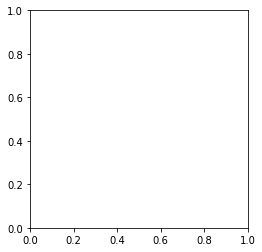

In [9]:
with torch.no_grad():
    
    for i in range(10):
        idx = random.randint(0,32)
        print(idx)
        input_image = inputs[idx].transpose(0, 1).transpose(1, 2)/256
                
        output = outputs[idx].transpose(0, 1).transpose(1, 2)/256
        output = output.cpu()
        
        target = targets[idx].transpose(0,1).transpose(1,2)/256
        target = target.cpu()
        

        plt.imshow(input_image)
        plt.show()
        plt.imshow(output)
        plt.show()
        plt.imshow(target)
        plt.show()
        print(np.linalg.norm(output-target))

In [ ]:
net.eval()

criterion = torch.nn.MSELoss()

train_loss = 0
correct = 0
total = 0
total_pixels = 0

for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader, leave=False)):
    inputs = inputs.float()
    inputs, targets = inputs.to(device), targets.to(device)
    print(targets.shape)
#     optimizer.zero_grad()
    outputs = net(inputs)
    
#     loss = criterion(outputs, targets)

    break


In [ ]:
# model training

net = get_model(args.model, args.width, args.depth)
start_epoch = 0
optimizer_state_dict = None

net = net.to(device)
pytorch_total_params = sum(p.numel() for p in net.parameters())
optimizer = get_optimizer(args.optimizer, args.model, net, args.lr)


In [ ]:
# def train_default(net, trainloader, optimizer_obj, device):

net.train()
net = net.to(device)
# optimizer = optimizer_obj.optimizer
# lr_scheduler = optimizer_obj.scheduler
# warmup_scheduler = optimizer_obj.warmup

# warmup_scheduler = warmup.ExponentialWarmup(optimizer, warmup_period=args.warmup_period)

# lr_scheduler = MultiStepLR(optimizer, milestones=args.lr_schedule, gamma=args.lr_factor,
#                        last_epoch=start_epoch-1)

# optimizer_obj = OptimizerWithSched(optimizer, lr_scheduler, warmup_scheduler)
    
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.MSELoss()

train_loss = 0
correct = 0
total = 0
total_pixels = 0

for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader, leave=False)):
    inputs, targets = inputs.to(device), targets.to(device)
    print(targets.shape)
#     optimizer.zero_grad()
    outputs = net(inputs)

    break



In [ ]:
targets = targets.float()
display(outputs.dtype)
display(targets.dtype)
# print(net.dtype)

In [ ]:
targets.size(0)

In [ ]:
print(outputs.shape)
print(targets.shape)

In [ ]:
# n, c, h, w = outputs.size()
# print(outputs.shape)
# reshaped_outputs = outputs.transpose(1, 2).transpose(2, 3).contiguous()
# print(reshaped_outputs.shape)
# # reshaped_outputs = reshaped_outputs[targets.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
# # print(reshaped_outputs.shape)
# reshaped_outputs = reshaped_outputs.view(-1, c)
# print(reshaped_outputs.shape)



In [ ]:
# # reshaped_inputs = inputs.transpose(1, 2).transpose(2, 3).contiguous()
# # reshaped_inputs = reshaped_inputs.mean(3).unsqueeze(-1)
# # reshaped_inputs = reshaped_inputs[targets.view(n, h, w, 1).repeat(1, 1, 1, 1) >= 0]
# # reshaped_inputs = reshaped_inputs.view(-1, 1)
# # path_mask = (reshaped_inputs > 0).squeeze()

# # mask = targets >= 0.0
# # reshaped_targets = targets[mask]

# reshaped_targets = targets.transpose(1, 2).transpose(2, 3).contiguous()
# reshaped_targets = reshaped_targets.view(-1, c)


# print(reshaped_outputs.shape)
# print(reshaped_targets.shape)

In [ ]:

loss = criterion(outputs, targets)
display(loss)
loss.backward()

# loss = criterion(reshaped_outputs.view(-1, 2), targets.view(-1))

    
#         loss = loss[path_mask].mean()
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item() * path_mask.size(0)
#         total_pixels += path_mask.size(0)

#         predicted = outputs.argmax(1) * inputs.max(1)[0]
#         correct += torch.amin(predicted == targets, dim=[1, 2]).sum().item()
#         total += targets.size(0)

#     train_loss = train_loss / total_pixels
#     acc = 100.0 * correct / total
#     lr_scheduler.step()
#     warmup_scheduler.dampen()

#     return train_loss, acc

In [ ]:
print(outputs.shape)
predicted = outputs.argmax(1)
print(predicted.shape, targets.shape)

correct += torch.amin(predicted == targets, dim=[1, 2]).sum().item()

In [ ]:
# visualize predictions 

import json
import pandas as pd

test_results_path = "test/test_stats.json"

with open(test_results_path) as f:
    test_results = json.load(f)

# print(test_results['num entries'])
del test_results['num entries']

df = pd.DataFrame.from_records(list(test_results.values()))
df

In [ ]:
df = df.iloc[16:20]

In [ ]:
import matplotlib.pyplot as plt

# df = df.drop_duplicates(subset=['model','test_iter'])

ff_results = df[df['test_iter']==-1]
ff_results['effective_depth'] = ff_results['model'].str.slice(13,15).astype(int)

rnn_results = df[df['test_iter']>0]
# rnn_results['effective_depth'] = rnn_results['model'].str.slice(16,18)

plt.figure()
# plt.subplot(211)
plt.plot( 
         rnn_results['test_iter']*4, rnn_results['test_acc'], 
#          ff_results['effective_depth'], ff_results['eval_acc'],
        )
plt.title("MSE Against #Iterations (denoising)")
plt.xlabel("test iterations")
plt.ylabel("MSE")

# rnn_results.plot('test_iter',['test_acc'])
# rnn_results.plot('test_iter',['eval_acc'])

# plt.axhline(y=61, color='orange', linestyle='-')

plt.legend(['recur_net','ff_net'])

plt.show()


In [ ]:
# visualize images

